In [21]:
import pandas as pd
import numpy as np
import joblib
import os
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [22]:
# --- Rutas y Parámetros ---
PROCESSED_PATH = "data_processed"
MODELS_PATH = "." 

# Parámetros (usados en entrenamiento previo)
TIMESTEP_DIA = 60
TIMESTEP_HORA = 504
TIMESTEP_MINUTO = 864 # Usamos este para la ventana de 5 minutos, aunque el output será horario

FEATURES_BASE = ['open', 'high', 'low', 'close', 'volume', 'volatilidad']
FEATURES_MINUTO = ['close'] # Univariado


# --- 1. Carga de Modelos y Escaladores ---
print("Cargando Modelos y Escaladores...")

# Cargamos los modelos Diarios y de 5 Minutos (los usaremos como "Base Predictors")
modelo_lstm_diario = load_model(os.path.join(MODELS_PATH, 'modelo_lstm_diario.h5'))
modelo_gru_diario = load_model(os.path.join(MODELS_PATH, 'modelo_gru_diario.h5'))
modelo_lstm_minuto = load_model(os.path.join(MODELS_PATH, 'modelo_lstm_cincoMinutos.keras'))
modelo_gru_minuto = load_model(os.path.join(MODELS_PATH, 'modelo_gru_cincoMinutos.keras'))

# Cargamos todos los escaladores
scaler_diario = joblib.load(os.path.join(MODELS_PATH, 'scaler_diario.pkl'))
scaler_horario = joblib.load(os.path.join(MODELS_PATH, 'scaler_horario.pkl'))
scaler_minuto = joblib.load(os.path.join(MODELS_PATH, 'scaler_cincoMinutos.pkl')) 


# --- 2. Carga de Datasets de Entrenamiento/Validación ---
print("Cargando Datasets de Testeo...")
df_diario_train_val = pd.read_csv(os.path.join(PROCESSED_PATH, "df_diario_train_val.csv"), index_col='timestamp', parse_dates=True)
df_horario_train_val = pd.read_csv(os.path.join(PROCESSED_PATH, "df_horario_train_val.csv"), index_col='timestamp', parse_dates=True)

# 🔴 MODIFICACIÓN CLAVE: Recortar el DataFrame de 5 minutos
# Solo necesitamos los datos recientes para el Meta-Learner.
# 6 meses de datos son aproximadamente 51,840 filas. Usaremos 55,000 por seguridad.
ROWS_TO_KEEP = 55000       #el que se debe usar 
#ROWS_TO_KEEP = 6500  #de prueba para ver que funcione todo bien
df_minuto_train_val_FULL = pd.read_csv(os.path.join(PROCESSED_PATH, "df_cincoMinutos_train_val.csv"), index_col='timestamp', parse_dates=True)
df_minuto_train_val = df_minuto_train_val_FULL.tail(ROWS_TO_KEEP)

print(f"Dataset de 5 minutos reducido a {len(df_minuto_train_val)} filas (aprox. últimos 6 meses).")

Cargando Modelos y Escaladores...


C:\Users\crges\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Cargando Datasets de Testeo...
Dataset de 5 minutos reducido a 55000 filas (aprox. últimos 6 meses).


In [23]:
## FUNCIONES AUXILIARES NECESARIAS

def crear_secuencias_train_val(df, scaler, timestep, features):
    """Prepara X_train_val para hacer predicciones (no para entrenar)"""
    
    # 1. Crear la característica de Volatilidad si está en la lista de features
    if 'volatilidad' in features and len(features) > 1:
        df['volatilidad'] = df['high'] - df['low']
    
    data = df[features].values
    scaled_data = scaler.transform(data)
    
    X_pred, Y_pred = [], []
    for i in range(timestep, len(scaled_data)):
        X_pred.append(scaled_data[i-timestep:i, :])
        Y_pred.append(scaled_data[i, features.index('close')])

    X_pred = np.array(X_pred)
    # Ajustar la forma para univariado (si es necesario)
    if len(features) == 1 and X_pred.ndim == 2:
        X_pred = np.expand_dims(X_pred, axis=2)
        
    return X_pred, np.array(Y_pred), df.index[timestep:]

def desescalar_prediccion(predictions_scaled, scaler, features_full):
    """Convierte las predicciones escaladas (0-1) a precios reales en USD."""
    close_idx = features_full.index('close') if 'close' in features_full else 0
    dummy_array = np.zeros(shape=(len(predictions_scaled), scaler.n_features_in_))
    dummy_array[:, close_idx] = predictions_scaled[:, 0]
    
    predictions_descaled = scaler.inverse_transform(dummy_array)
    precios_reales = predictions_descaled[:, close_idx]
    
    return precios_reales

In [24]:
## GENERACIÓN DE PREDICCIONES BASE PARA EL META-LEARNER

# --- A. Predicción Diaria (Largo Plazo) ---
print("\n--- A. Generando Predicción Diaria Base (Largo Plazo) ---")

X_diario_base, Y_diario_base, indices_diarios = crear_secuencias_train_val(
    df_diario_train_val.copy(), scaler_diario, TIMESTEP_DIA, FEATURES_BASE
)

# Generar y promediar predicciones
pred_scaled_diario = (modelo_lstm_diario.predict(X_diario_base) + modelo_gru_diario.predict(X_diario_base)) / 2
pred_reales_diario_base = desescalar_prediccion(pred_scaled_diario, scaler_diario, FEATURES_BASE)

df_pred_diaria_base = pd.DataFrame(
    pred_reales_diario_base, index=indices_diarios, columns=['pred_diaria']
)


# --- B. Predicción de 5 Minutos (Corto Plazo) ---
print("\n--- B. Generando Predicción 5 Minutos Base (Corto Plazo) ---")

X_minuto_base, Y_minuto_base, indices_minuto = crear_secuencias_train_val(
    df_minuto_train_val.copy(), scaler_minuto, TIMESTEP_MINUTO, FEATURES_MINUTO
)

pred_scaled_minuto = (modelo_lstm_minuto.predict(X_minuto_base) + modelo_gru_minuto.predict(X_minuto_base)) / 2

# Usamos el inverse_transform directamente sobre el scaler_minuto (tamaño 1)

# 1. Asegurarse de que el array tenga la forma (N, 1) que espera inverse_transform
predictions_scaled_reshaped = pred_scaled_minuto.reshape(-1, 1) 

# 2. Aplicar inverse_transform directamente
pred_reales_minuto_base = scaler_minuto.inverse_transform(predictions_scaled_reshaped)

# El resultado es un array 2D, lo aplanamos a 1D para el DataFrame
pred_reales_minuto_base = pred_reales_minuto_base.flatten()


df_pred_minuto_base = pd.DataFrame(
    pred_reales_minuto_base, index=indices_minuto, columns=['pred_5min']
)

print("✅ Predicciones base generadas con éxito.")


--- A. Generando Predicción Diaria Base (Largo Plazo) ---
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

--- B. Generando Predicción 5 Minutos Base (Corto Plazo) ---
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 166s 98ms/step
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 149s 88ms/step
✅ Predicciones base generadas con éxito.


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

def crear_modelo_lstm_meta(timestep, n_features, neuronas=50, dropout=0.2):
    """Crea el modelo LSTM con 8 features de entrada."""
    model = Sequential()
    # Input shape ahora es (TIMESTEP_HORA_META, 8)
    model.add(LSTM(neuronas, return_sequences=True, input_shape=(timestep, n_features)))
    model.add(Dropout(dropout))
    model.add(LSTM(neuronas, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1)) # Output: 1 (precio de cierre)
    model.compile(optimizer='adam', loss='mse')
    return model

def crear_modelo_gru_meta(timestep, n_features, neuronas=50, dropout=0.2):
    """Crea el modelo GRU con 8 features de entrada."""
    model = Sequential()
    # Input shape ahora es (TIMESTEP_HORA_META, 8)
    model.add(GRU(neuronas, return_sequences=True, input_shape=(timestep, n_features)))
    model.add(Dropout(dropout))
    model.add(GRU(neuronas, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1)) # Output: 1 (precio de cierre)
    model.compile(optimizer='adam', loss='mse')
    return model

In [26]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

# ----------------------------------------------------------------------
# --- BLOQUE 1: CARGA DE DATOS Y PREPARACIÓN DE FEATURES BASE (6) ---
# ----------------------------------------------------------------------

# Define la ruta de la carpeta procesada
PROCESSED_DATA_PATH = "data_processed" 

# Carga de datos (Asumiendo que 'os' está importado)
df_train_val = pd.read_csv(
    os.path.join(PROCESSED_DATA_PATH, "df_horario_train_val.csv"), 
    index_col='timestamp', 
    parse_dates=True
)
# df_test_final (necesario para la consistencia, aunque no se usa en el Meta-Train)
df_test_final = pd.read_csv(
    os.path.join(PROCESSED_DATA_PATH, "df_horario_test_final.csv"), 
    index_col='timestamp', 
    parse_dates=True
)

# 2. Creación de la característica de Volatilidad
df_train_val['volatilidad'] = df_train_val['high'] - df_train_val['low']
df_test_final['volatilidad'] = df_test_final['high'] - df_test_final['low']

# 3. Definir las características
FEATURES_BASE = ['open', 'high', 'low', 'close', 'volume', 'volatilidad']
TIMESTEP = 504 # 3 semanas * 7 días * 24 horas = 504 horas
TIMESTEP_HORA_META = TIMESTEP 

# Crear escalador base (Solo para consistencia con el flujo original, aunque no se usa aquí)
scaler_horario = MinMaxScaler(feature_range=(0, 1))
data_train_val = df_train_val[FEATURES_BASE].values 
scaler_horario.fit(data_train_val)

print("--- Data Base Cargada y Features Base (6) Preparadas ---")

# ----------------------------------------------------------------------
# --- BLOQUE 2: ALINEACIÓN Y CONSTRUCCIÓN DEL DATASET META (8 FEATURES) ---
# ----------------------------------------------------------------------

# Variables para el Meta-Learner
features_new = FEATURES_BASE + ['pred_diaria', 'pred_5min']
CLOSE_INDEX_NEW = features_new.index('close') # Índice de la columna 'close' en las 8 features

print("\n--- 4. ALINEACIÓN Y CONSTRUCCIÓN DEL DATASET DE ENTRENAMIENTO META ---")

# 1. IDENTIFICAR EL ÍNDICE MAESTRO (Recorte por TIMESTEP)
# Las secuencias inician en la fila TIMESTEP. El índice maestro comienza allí.
indice_inicio_valido = df_train_val.index[TIMESTEP]
indices_maestros = df_train_val.index[TIMESTEP:]


# 2. PREPARACIÓN DE LA PREDICCIÓN DIARIA
# Reindexar el DF diario a la frecuencia horaria (ffill)
df_pred_diaria_horaria = df_pred_diaria_base.reindex(df_train_val.index, method='ffill')
df_pred_diaria_horaria.columns = ['pred_diaria'] # Renombrar para evitar KeyErrors
# Recortar solo a los índices de entrenamiento Horario (índice maestro)
pred_diaria_train = df_pred_diaria_horaria.loc[indices_maestros]


# 3. PREPARACIÓN DE LA PREDICCIÓN 5 MINUTOS
# Agregación por hora (resample 'H'). Asumo que la columna de predicción es la única.
df_pred_minuto_horaria = df_pred_minuto_base.resample('H').mean()
df_pred_minuto_horaria.columns = ['pred_5min'] # Renombrar
# Recortar solo a los índices de entrenamiento Horario (índice maestro)
pred_5min_train = df_pred_minuto_horaria.reindex(indices_maestros)

# 4. CONSTRUCCIÓN FINAL Y ALINEACIÓN (8 FEATURES)

# A. Concatenar las 2 nuevas features y eliminar posibles NaN adicionales
df_new_features = pd.concat([pred_diaria_train, pred_5min_train], axis=1).dropna()

# B. Alineamos el DF Horario original (6 features) al índice final limpio
df_horario_final = df_train_val.loc[df_new_features.index, FEATURES_BASE]

# C. Concatenar las 6 features originales con las 2 nuevas
data_completa_limpia = pd.concat([df_horario_final, df_new_features], axis=1)

# D. Escalar las 8 Features
new_scaler_horario = MinMaxScaler(feature_range=(0, 1))
data_to_scale = data_completa_limpia[features_new].values
scaled_data_final = new_scaler_horario.fit_transform(data_to_scale)


--- Data Base Cargada y Features Base (6) Preparadas ---

--- 4. ALINEACIÓN Y CONSTRUCCIÓN DEL DATASET DE ENTRENAMIENTO META ---


C:\Users\crges\AppData\Local\Temp\ipykernel_18372\1037406599.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_pred_minuto_horaria = df_pred_minuto_base.resample('H').mean()


In [27]:
# ... (código anterior del Paso 5, incluyendo la inicialización de listas y el bucle for)

# 5. CREACIÓN FINAL DE SECUENCIAS (X_train_final, Y_train_final)

X_train_final = []
Y_train_final = [] 
close_idx = features_new.index('close') 

# Iterar sobre el array escalado. 
for i in range(TIMESTEP_HORA_META, len(scaled_data_final)):
    # X_train: Ventana de 504 valores anteriores (8 features)
    # Esta porción ya es 2D: (504, 8)
    X_train_final.append(scaled_data_final[i-TIMESTEP_HORA_META:i, :]) 
    
    # Y_train: Precio de Cierre del paso siguiente
    Y_train_final.append(scaled_data_final[i, close_idx])


# 🚨 CONVERSIÓN CRÍTICA: Debemos asegurarnos de que X sea 3D 🚨
X_train_final = np.array(X_train_final) 
Y_train_final = np.array(Y_train_final)

# Si X_train_final resulta ser 2D (muestras x 504*8), podemos intentar reformatear:
# if X_train_final.ndim == 2 and X_train_final.shape[1] % TIMESTEP_HORA_META == 0:
#    n_features = X_train_final.shape[1] // TIMESTEP_HORA_META
#    X_train_final = X_train_final.reshape(-1, TIMESTEP_HORA_META, n_features)

# Si la conversión a array de NumPy es correcta, la forma debería ser (N, 504, 8)
print("\n--- Set de Entrenamiento Meta-Learner Creado ---")
print(f"Forma de X_train_final: {X_train_final.shape}")
print(f"Forma de Y_train_final: {Y_train_final.shape}")
print("X_train_final.shape",X_train_final.shape);


--- Set de Entrenamiento Meta-Learner Creado ---
Forma de X_train_final: (4007, 504, 8)
Forma de Y_train_final: (4007,)
X_train_final.shape (4007, 504, 8)


In [28]:
## 🧠 BLOQUE DE ENTRENAMIENTO DEL META-LEARNER 🧠

from tensorflow.keras.callbacks import EarlyStopping
import os # 👈 Asegurar la importación
# from .... import crear_modelo_lstm_meta, crear_modelo_gru_meta # (Asegurar que estas funciones estén definidas)

# --- PARÁMETROS DE RUTAS Y ENTRENAMIENTO ---
# 🚨 Asegúrate de que esta variable sea correcta.
MODELS_PATH = "." 
EPOCHS = 20
BATCH_SIZE = 64
# Las variables X_train_final, Y_train_final y TIMESTEP_HORA_META deben provenir del bloque anterior.

# Obtener el número de features (debe ser 8)
N_FEATURES_META = X_train_final.shape[2] 
print(f"Número de Features de Entrada para el Meta-Learner: {N_FEATURES_META}")

# Callbacks para evitar overfitting y ahorrar tiempo
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

# --------------------------------------------------------
# 1. ENTRENAMIENTO DEL MODELO LSTM META-LEARNER
# --------------------------------------------------------
print("\n--- 1. Entrenando LSTM Meta-Learner (8 Features) ---")
print(f"Forma de entrada X: {X_train_final.shape}")

# Crear el modelo usando la función del BLOQUE 4
modelo_lstm_meta = crear_modelo_lstm_meta(TIMESTEP_HORA_META, N_FEATURES_META) 

hist_lstm_meta = modelo_lstm_meta.fit(
    X_train_final, 
    Y_train_final, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    callbacks=[early_stopping], 
    verbose=1
)

# Guardar el modelo entrenado
modelo_lstm_meta.save(os.path.join(MODELS_PATH, 'modelo_lstm_meta.h5'))
print("✅ LSTM Meta-Learner guardado.")


# --------------------------------------------------------
# 2. ENTRENAMIENTO DEL MODELO GRU META-LEARNER
# --------------------------------------------------------
print("\n--- 2. Entrenando GRU Meta-Learner (8 Features) ---")

# Crear el modelo usando la función del BLOQUE 4
modelo_gru_meta = crear_modelo_gru_meta(TIMESTEP_HORA_META, N_FEATURES_META) 

hist_gru_meta = modelo_gru_meta.fit(
    X_train_final, 
    Y_train_final, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    callbacks=[early_stopping], 
    verbose=1
)

# Guardar el modelo entrenado
modelo_gru_meta.save(os.path.join(MODELS_PATH, 'modelo_gru_meta.h5'))
print("✅ GRU Meta-Learner guardado.")

print("\n--- ✅ Entrenamiento del Stacking (Meta-Learner) Completado ---")

Número de Features de Entrada para el Meta-Learner: 8

--- 1. Entrenando LSTM Meta-Learner (8 Features) ---
Forma de entrada X: (4007, 504, 8)


C:\Users\crges\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 337ms/step - loss: 0.0181 - val_loss: 0.0011
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 335ms/step - loss: 0.0017 - val_loss: 6.6514e-04
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 338ms/step - loss: 0.0015 - val_loss: 9.5523e-04
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 445ms/step - loss: 0.0013 - val_loss: 4.8527e-04
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 418ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 431ms/step - loss: 0.0012 - val_loss: 5.9716e-04
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 429ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 424ms/step - loss: 0.0013 - val_loss: 4.1777e-04
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 443ms/step - loss: 0.0011 - val_loss: 3.9949e-04
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 412ms/step - loss: 0.0011 - val_loss: 7.5147e-04
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 446ms/step - loss: 0.0010 - val_loss: 0.0035
Epoch 12/20
5

✅ LSTM Meta-Learner guardado.

--- 2. Entrenando GRU Meta-Learner (8 Features) ---
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 486ms/step - loss: 0.0151 - val_loss: 2.8278e-04
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 413ms/step - loss: 0.0024 - val_loss: 3.5910e-04
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step - loss: 0.0018 - val_loss: 7.2295e-04
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 413ms/step - loss: 0.0016 - val_loss: 2.6091e-04
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - loss: 0.0014 - val_loss: 2.7477e-04
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 397ms/step - loss: 0.0012 - val_loss: 2.4608e-04
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step - loss: 0.0012 - val_loss: 2.7638e-04
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - loss: 0.0012 - val_loss: 7.2933e-04
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 407ms/step - loss: 0.0011 - val_loss: 2.4618e-04
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 405ms/step - loss: 0.0011 - val_loss: 4.9726e-04
Epoch 

✅ GRU Meta-Learner guardado.

--- ✅ Entrenamiento del Stacking (Meta-Learner) Completado ---


In [44]:
## ⚙️ BLOQUE DE REGENERACIÓN DEL META-DATASET Y GUARDADO DEL SCALER 💾

import numpy as np
import pandas as pd
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
# Asegúrate de que las variables globales (TIMESTEP_HORA_META, FEATURES_BASE, 
# PROCESSED_PATH, MODELS_PATH, df_train_val, df_pred_diaria_base, df_pred_minuto_base) 
# estén disponibles en memoria.

TIMESTEP_HORA_META = 504 # O el valor correcto que uses

print("\n--- INICIO DE REGENERACIÓN DEL META-DATASET ---")

# --------------------------------------------------------
# 1. ALINEACIÓN DE ÍNDICES Y CONSTRUCCIÓN DEL DATAFRAME DE 8 FEATURES
# --------------------------------------------------------
features_new = FEATURES_BASE + ['pred_diaria', 'pred_5min']
print(f"Features finales para el Meta-Learner: {features_new}")

# Identificar el índice maestro limpio (donde podemos tener 504 pasos anteriores)
indices_maestros = df_train_val.index[TIMESTEP_HORA_META:]

# 1.1 ALINEAR PREDICCIÓN DIARIA
# Reindexar a la frecuencia horaria y rellenar con el valor anterior
df_pred_diaria_horaria = df_pred_diaria_base.reindex(df_train_val.index, method='ffill')
df_pred_diaria_horaria.columns = ['pred_diaria']
pred_diaria_train = df_pred_diaria_horaria.loc[indices_maestros] # Recorte al índice maestro

# 1.2 ALINEAR PREDICCIÓN 5 MINUTOS
# Remuestrear a la frecuencia horaria y reindexar al índice maestro
df_pred_minuto_horaria = df_pred_minuto_base.resample('H').mean()
df_pred_minuto_horaria.columns = ['pred_5min'] 
pred_5min_train = df_pred_minuto_horaria.reindex(indices_maestros) 

# 1.3 CONCATENACIÓN Y LIMPIEZA FINAL
# Concatenar las 2 nuevas features y eliminar posibles NaN adicionales
df_new_features = pd.concat([pred_diaria_train, pred_5min_train], axis=1).dropna() 

# Alineamos el DF Horario original (6 features) al índice final limpio
df_horario_final = df_train_val.loc[df_new_features.index, FEATURES_BASE]

# Concatenar las 6 features originales con las 2 nuevas
data_completa_limpia = pd.concat([df_horario_final, df_new_features], axis=1) # ⬅️ Variable 'data_completa_limpia' regenerada

print(f"Longitud del DataFrame final limpio (8 Features): {len(data_completa_limpia)}")

# --------------------------------------------------------
# 2. ESCALADO Y GUARDADO DEL SCALER (LA PARTE QUE FALTÓ)
# --------------------------------------------------------

# Crear y ajustar el nuevo scaler con las 8 features
new_scaler_horario = MinMaxScaler(feature_range=(0, 1))
data_to_fit = data_completa_limpia[features_new].values # Usamos las 8 features

# Hacemos el fit_transform (aunque solo necesitamos el fit para el guardado)
scaled_data_final = new_scaler_horario.fit_transform(data_to_fit)

# 💾 GUARDA EL SCALER PARA USARLO EN EL TESTEO
joblib.dump(new_scaler_horario, os.path.join(MODELS_PATH, 'new_scaler_horario.pkl'))
print(f"✅ 'new_scaler_horario.pkl' guardado en: {os.path.join(MODELS_PATH, 'new_scaler_horario.pkl')}")

# --------------------------------------------------------
# 3. CREACIÓN FINAL DE SECUENCIAS (X_train_final, Y_train_final)
# --------------------------------------------------------

X_train_final = []
Y_train_final = [] 
close_idx = features_new.index('close') # El índice de la columna 'close' dentro de las 8 features

# Iterar sobre el array escalado. 
for i in range(TIMESTEP_HORA_META, len(scaled_data_final)):
    # X_train: Ventana de 504 valores anteriores (8 features)
    X_train_final.append(scaled_data_final[i-TIMESTEP_HORA_META:i, :]) 
    
    # Y_train: Precio de Cierre del paso siguiente (escalado)
    Y_train_final.append(scaled_data_final[i, close_idx])

# Convertir a NumPy arrays (solución del error anterior)
X_train_final, Y_train_final = np.array(X_train_final), np.array(Y_train_final) 

print("\n--- Set de Entrenamiento Meta-Learner Creado ---")
print(f"Forma de X_train_final: {X_train_final.shape}")
print(f"Forma de Y_train_final: {Y_train_final.shape}")
print("--- ✅ Regeneración de Meta-Data Completada ---")


--- INICIO DE REGENERACIÓN DEL META-DATASET ---
Features finales para el Meta-Learner: ['open', 'high', 'low', 'close', 'volume', 'volatilidad', 'pred_diaria', 'pred_5min']
Longitud del DataFrame final limpio (8 Features): 4511
✅ 'new_scaler_horario.pkl' guardado en: .\new_scaler_horario.pkl

--- Set de Entrenamiento Meta-Learner Creado ---
Forma de X_train_final: (4007, 504, 8)
Forma de Y_train_final: (4007,)
--- ✅ Regeneración de Meta-Data Completada ---


C:\Users\crges\AppData\Local\Temp\ipykernel_18372\200444818.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_pred_minuto_horaria = df_pred_minuto_base.resample('H').mean()


In [45]:
import pandas as pd
import numpy as np
import os
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError # 👈 CAMBIO CRÍTICO: Importamos la CLASE MSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------------------------------------------------
# --- BLOQUE FINAL: PREDICCIÓN Y EVALUACIÓN DEL STACKING ---
# ----------------------------------------------------------------------

print("--- INICIO DE PREDICCIÓN Y EVALUACIÓN DEL META-LEARNER EN TEST ---")

# --- 1. CARGA DE COMPONENTES Y DATA DE TESTEO (SOLUCIÓN ERROR DE CARGA) ---
MODELS_PATH = "." 
PROCESSED_PATH = "data_processed"
TIMESTEP_HORA_META = 504 
FEATURES_BASE = ['open', 'high', 'low', 'close', 'volume', 'volatilidad']
FEATURES_MINUTO = ['close']

# 🔑 SOLUCIÓN: Referenciamos la CLASE MeanSquaredError
# Utilizamos MeanSquaredError() para referenciar la función de pérdida usada al compilar.
CUSTOM_OBJECTS = {'mse': MeanSquaredError()} 

try:
    # 1.1 Carga de Modelos, Escaladores y el Scaler Meta Final
    # 🔴 APLICACIÓN DE custom_objects
    modelo_lstm_meta = load_model(
        os.path.join(MODELS_PATH, 'modelo_lstm_meta.h5'), 
        custom_objects=CUSTOM_OBJECTS
    )
    modelo_gru_meta = load_model(
        os.path.join(MODELS_PATH, 'modelo_gru_meta.h5'),
        custom_objects=CUSTOM_OBJECTS
    )
    
    # ... (El resto del código de carga continúa sin cambios)
    new_scaler_horario = joblib.load(os.path.join(MODELS_PATH, 'new_scaler_horario.pkl'))
    
    # Modelos Base y Escaladores
    modelo_lstm_diario = load_model(os.path.join(MODELS_PATH, 'modelo_lstm_diario.h5'))
    modelo_gru_diario = load_model(os.path.join(MODELS_PATH, 'modelo_gru_diario.h5'))
    modelo_lstm_minuto = load_model(os.path.join(MODELS_PATH, 'modelo_lstm_cincoMinutos.keras'))
    modelo_gru_minuto = load_model(os.path.join(MODELS_PATH, 'modelo_gru_cincoMinutos.keras'))
    
    scaler_diario = joblib.load(os.path.join(MODELS_PATH, 'scaler_diario.pkl'))
    scaler_minuto = joblib.load(os.path.join(MODELS_PATH, 'scaler_cincoMinutos.pkl')) 
    
    # 1.2 Carga de Dataframes de Testeo
    df_test_final = pd.read_csv(os.path.join(PROCESSED_PATH, "df_horario_test_final.csv"), index_col='timestamp', parse_dates=True)
    df_test_final['volatilidad'] = df_test_final['high'] - df_test_final['low']
    
    df_diario_test_final = pd.read_csv(os.path.join(PROCESSED_PATH, "df_diario_test_final.csv"), index_col='timestamp', parse_dates=True)
    df_minuto_test_final = pd.read_csv(os.path.join(PROCESSED_PATH, "df_cincoMinutos_test_final.csv"), index_col='timestamp', parse_dates=True)

except FileNotFoundError as e:
    print(f"Error: No se pudo cargar un archivo necesario. Asegúrate de que todos los modelos, escaladores y DataFrames de testeo estén guardados correctamente. Error: {e}")
    raise

--- INICIO DE PREDICCIÓN Y EVALUACIÓN DEL META-LEARNER EN TEST ---


C:\Users\crges\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [46]:
import pandas as pd
import numpy as np
import os
import joblib
from tensorflow.keras import losses
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------------------------------------------------
# --- BLOQUE FINAL: PREDICCIÓN Y EVALUACIÓN DEL STACKING ---
# ----------------------------------------------------------------------

print("--- INICIO DE PREDICCIÓN Y EVALUACIÓN DEL META-LEARNER EN TEST ---")

# --- 1. CARGA DE COMPONENTES Y DATA DE TESTEO (SOLUCIÓN ERROR DESERIALIZACIÓN) ---
MODELS_PATH = "." 
PROCESSED_PATH = "data_processed"
TIMESTEP_HORA_META = 504 
FEATURES_BASE = ['open', 'high', 'low', 'close', 'volume', 'volatilidad']
FEATURES_MINUTO = ['close']

# 🔑 SOLUCIÓN: Definir la métrica MSE para que Keras pueda cargar el modelo
CUSTOM_OBJECTS = {'mse': MeanSquaredError()} 

try:
    # 1.1 Carga de Modelos, Escaladores y el Scaler Meta Final
    # 🔴 APLICACIÓN DE custom_objects
    modelo_lstm_meta = load_model(
        os.path.join(MODELS_PATH, 'modelo_lstm_meta.h5'), 
        custom_objects=CUSTOM_OBJECTS
    )
    modelo_gru_meta = load_model(
        os.path.join(MODELS_PATH, 'modelo_gru_meta.h5'),
        custom_objects=CUSTOM_OBJECTS
    )
    new_scaler_horario = joblib.load(os.path.join(MODELS_PATH, 'new_scaler_horario.pkl'))
    
    # Modelos Base y Escaladores (Necesarios para generar las predicciones base de test)
    # Por si acaso, aplicamos custom_objects también a los modelos base (aunque puede no ser necesario)
    modelo_lstm_diario = load_model(os.path.join(MODELS_PATH, 'modelo_lstm_diario.h5'))
    modelo_gru_diario = load_model(os.path.join(MODELS_PATH, 'modelo_gru_diario.h5'))
    modelo_lstm_minuto = load_model(os.path.join(MODELS_PATH, 'modelo_lstm_cincoMinutos.keras'))
    modelo_gru_minuto = load_model(os.path.join(MODELS_PATH, 'modelo_gru_cincoMinutos.keras'))
    
    scaler_diario = joblib.load(os.path.join(MODELS_PATH, 'scaler_diario.pkl'))
    scaler_minuto = joblib.load(os.path.join(MODELS_PATH, 'scaler_cincoMinutos.pkl')) 
    
    # 1.2 Carga de Dataframes de Testeo
    # Data Horaria (Principal)
    df_test_final = pd.read_csv(os.path.join(PROCESSED_PATH, "df_horario_test_final.csv"), index_col='timestamp', parse_dates=True)
    df_test_final['volatilidad'] = df_test_final['high'] - df_test_final['low'] # Agregar volatilidad
    
    # Data Diaria y 5 Minutos (Para generar las features de predicción)
    df_diario_test_final = pd.read_csv(os.path.join(PROCESSED_PATH, "df_diario_test_final.csv"), index_col='timestamp', parse_dates=True)
    df_minuto_test_final = pd.read_csv(os.path.join(PROCESSED_PATH, "df_cincoMinutos_test_final.csv"), index_col='timestamp', parse_dates=True)

except FileNotFoundError as e:
    print(f"Error: No se pudo cargar un archivo necesario. Asegúrate de que todos los modelos, escaladores y DataFrames de testeo estén guardados correctamente. Error: {e}")
    raise


--- INICIO DE PREDICCIÓN Y EVALUACIÓN DEL META-LEARNER EN TEST ---


C:\Users\crges\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [48]:
# ----------------------------------------------------------------------
# --- 2. GENERACIÓN DE PREDICCIONES BASE EN EL SET DE TESTEO (NUEVAS FEATURES) ---
# ----------------------------------------------------------------------
print("\n--- Generando PREDICCIONES BASE para el Set de TESTEO ---")

# --- A. Predicción Diaria (Largo Plazo) ---
# Usamos df_diario_test_final como INPUT
X_diario_test, _, indices_diarios_test = crear_secuencias_train_val(
    df_diario_test_final.copy(), scaler_diario, TIMESTEP_DIA, FEATURES_BASE
)
pred_scaled_diario_test = (modelo_lstm_diario.predict(X_diario_test) + modelo_gru_diario.predict(X_diario_test)) / 2
pred_reales_diario_test = desescalar_prediccion(pred_scaled_diario_test, scaler_diario, FEATURES_BASE)
df_pred_diaria_test = pd.DataFrame(
    pred_reales_diario_test, index=indices_diarios_test, columns=['pred_diaria']
)


# --- B. Predicción de 5 Minutos (Corto Plazo) ---
# Usamos df_minuto_test_final como INPUT
X_minuto_test, _, indices_minuto_test = crear_secuencias_train_val(
    df_minuto_test_final.copy(), scaler_minuto, TIMESTEP_MINUTO, FEATURES_MINUTO
)
pred_scaled_minuto_test = (modelo_lstm_minuto.predict(X_minuto_test) + modelo_gru_minuto.predict(X_minuto_test)) / 2
predictions_scaled_reshaped = pred_scaled_minuto_test.reshape(-1, 1)
pred_reales_minuto_test = scaler_minuto.inverse_transform(predictions_scaled_reshaped).flatten()
df_pred_minuto_test = pd.DataFrame(
    pred_reales_minuto_test, index=indices_minuto_test, columns=['pred_5min']
)

print("✅ Predicciones base de testeo generadas con éxito.")





--- Generando PREDICCIONES BASE para el Set de TESTEO ---
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2373/2373 ━━━━━━━━━━━━━━━━━━━━ 163s 68ms/step
2373/2373 ━━━━━━━━━━━━━━━━━━━━ 147s 62ms/step
✅ Predicciones base de testeo generadas con éxito.


In [49]:
# ----------------------------------------------------------------------
# --- 3. PREPARACIÓN DEL DATASET META DE TESTEO (X_test_final) ---
# ----------------------------------------------------------------------
features_new = FEATURES_BASE + ['pred_diaria', 'pred_5min']
CLOSE_INDEX_NEW = features_new.index('close')

print("\n--- Preparando Meta-Dataset de Testeo (Alineación y Escalado) ---")

# 1. IDENTIFICAR EL ÍNDICE MAESTRO DE TESTEO (Recorte por TIMESTEP=504)
indices_maestros_test = df_test_final.index[TIMESTEP_HORA_META:]

# 2. ALINEACIÓN DE LAS 8 FEATURES (Misma lógica que en el training)
# Predicción Diaria
df_pred_diaria_horaria_test = df_pred_diaria_test.reindex(df_test_final.index, method='ffill')
df_pred_diaria_horaria_test.columns = ['pred_diaria']
pred_diaria_test_aligned = df_pred_diaria_horaria_test.loc[indices_maestros_test]

# Predicción 5 Minutos
df_pred_minuto_horaria_test = df_pred_minuto_test.resample('H').mean()
df_pred_minuto_horaria_test.columns = ['pred_5min'] 
pred_5min_test_aligned = df_pred_minuto_horaria_test.reindex(indices_maestros_test) # Uso de reindex robusto

# CONSTRUCCIÓN FINAL Y ESCALADO
df_new_features_test = pd.concat([pred_diaria_test_aligned, pred_5min_test_aligned], axis=1).dropna()
df_horario_final_test = df_test_final.loc[df_new_features_test.index, FEATURES_BASE]
data_completa_limpia_test = pd.concat([df_horario_final_test, df_new_features_test], axis=1)

# Aplicar el ESCALADOR YA AJUSTADO (new_scaler_horario)
data_to_transform_test = data_completa_limpia_test[features_new].values
scaled_data_final_test = new_scaler_horario.transform(data_to_transform_test) # <--- SOLO TRANSFORM!

# 3. CREACIÓN FINAL DE SECUENCIAS
X_test_final = []
Y_test_final = [] 
for i in range(TIMESTEP_HORA_META, len(scaled_data_final_test)):
    X_test_final.append(scaled_data_final_test[i-TIMESTEP_HORA_META:i, :]) 
    Y_test_final.append(scaled_data_final_test[i, CLOSE_INDEX_NEW])

X_test_final = np.array(X_test_final)
Y_test_final = np.array(Y_test_final)
print(f"Forma de X_test_final: {X_test_final.shape}")



--- Preparando Meta-Dataset de Testeo (Alineación y Escalado) ---
Forma de X_test_final: (4456, 504, 8)


C:\Users\crges\AppData\Local\Temp\ipykernel_18372\686581837.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_pred_minuto_horaria_test = df_pred_minuto_test.resample('H').mean()


In [50]:
# ----------------------------------------------------------------------
# --- 4. PREDICCIÓN FINAL Y EVALUACIÓN ---
# ----------------------------------------------------------------------

print("\n--- Generando Predicción Final del Stacking (Meta-Learner) ---")
# 1. Generar predicción promediada del Meta-Learner
pred_lstm_scaled = modelo_lstm_meta.predict(X_test_final)
pred_gru_scaled = modelo_gru_meta.predict(X_test_final)

pred_meta_scaled = (pred_lstm_scaled + pred_gru_scaled) / 2
pred_meta_scaled_reshaped = pred_meta_scaled.reshape(-1, 1)

# 2. Desescalar Predicciones y Valores Reales (Usando el new_scaler_horario)
pred_meta_reales = desescalar_prediccion(pred_meta_scaled_reshaped, new_scaler_horario, features_new)
Y_test_reales = desescalar_prediccion(Y_test_final.reshape(-1, 1), new_scaler_horario, features_new)

# 3. Evaluación
mae = mean_absolute_error(Y_test_reales, pred_meta_reales)
rmse = np.sqrt(mean_squared_error(Y_test_reales, pred_meta_reales))
mape = np.mean(np.abs((Y_test_reales - pred_meta_reales) / Y_test_reales)) * 100

print("\n--- ✅ RESULTADOS FINALES DEL META-LEARNER EN EL SET DE TESTEO ---")
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")
print(f"MAPE (Error Porcentual Absoluto Medio): {mape:.2f}%")
print("-------------------------------------------------------------------")


--- Generando Predicción Final del Stacking (Meta-Learner) ---
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step

--- ✅ RESULTADOS FINALES DEL META-LEARNER EN EL SET DE TESTEO ---
MAE (Error Absoluto Medio): 1025.6892
RMSE (Raíz del Error Cuadrático Medio): 1312.9280
MAPE (Error Porcentual Absoluto Medio): 0.95%
-------------------------------------------------------------------


--- GENERANDO GRÁFICA DE PREDICCIÓN VS. REALIDAD ---


C:\Users\crges\AppData\Local\Temp\ipykernel_18372\2154824784.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_pred_minuto_horaria_test = df_pred_minuto_test.resample('H').mean()


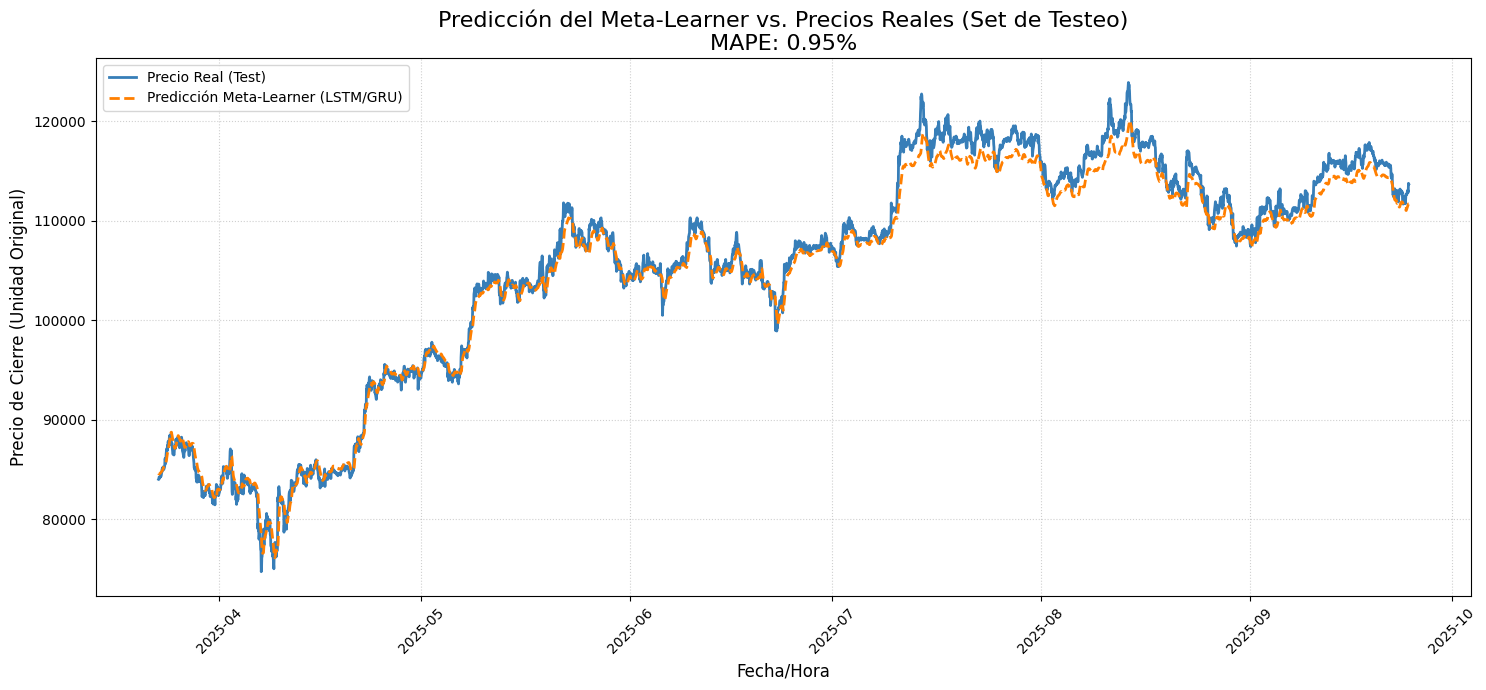

✅ Gráfica generada con éxito. 


In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Necesitarás df_test_final y las predicciones/reales del último bloque

print("--- GENERANDO GRÁFICA DE PREDICCIÓN VS. REALIDAD ---")

# 1. Obtener el índice de tiempo real
# El número de muestras de X_test_final es la longitud de pred_meta_reales.
# Estos corresponden a los últimos N índices del DataFrame de testeo.
# Primero, obtenemos el índice de data_completa_limpia_test (generado en el Bloque 3 de Predicción)
# Si esa variable no está en memoria, la regeneramos:

# --------------------------------------------------------
# REGENERACIÓN DEL ÍNDICE ALINEADO (Paso 3 del bloque anterior)
# --------------------------------------------------------
TIMESTEP_HORA_META = 504 
features_new = ['open', 'high', 'low', 'close', 'volume', 'volatilidad', 'pred_diaria', 'pred_5min']

# Asumimos que df_test_final, df_pred_diaria_test y df_pred_minuto_test existen en memoria.
indices_maestros_test = df_test_final.index[TIMESTEP_HORA_META:]

# Alineación (replicando el Paso 3 de la preparación de testeo)
df_pred_diaria_horaria_test = df_pred_diaria_test.reindex(df_test_final.index, method='ffill')
df_pred_diaria_horaria_test.columns = ['pred_diaria']
pred_diaria_test_aligned = df_pred_diaria_horaria_test.loc[indices_maestros_test]

df_pred_minuto_horaria_test = df_pred_minuto_test.resample('H').mean()
df_pred_minuto_horaria_test.columns = ['pred_5min'] 
pred_5min_test_aligned = df_pred_minuto_horaria_test.reindex(indices_maestros_test) 

df_new_features_test = pd.concat([pred_diaria_test_aligned, pred_5min_test_aligned], axis=1).dropna()
df_horario_final_test = df_test_final.loc[df_new_features_test.index, FEATURES_BASE]
data_completa_limpia_test = pd.concat([df_horario_final_test, df_new_features_test], axis=1)

# El índice que usamos para el testeo es desde el paso TIMESTEP_HORA_META en adelante:
N_samples = len(pred_meta_reales) # 4007 muestras en tu caso
test_index = data_completa_limpia_test.index[-N_samples:]

# --------------------------------------------------------
# 2. CONSTRUCCIÓN DEL DATAFRAME DE RESULTADOS
# --------------------------------------------------------

df_results = pd.DataFrame({
    'Real': Y_test_reales.flatten(),
    'Predicción': pred_meta_reales.flatten()
}, index=test_index)


# --------------------------------------------------------
# 3. GENERACIÓN DE LA GRÁFICA
# --------------------------------------------------------

plt.figure(figsize=(15, 7))

# Gráfica de la realidad
plt.plot(df_results['Real'], label='Precio Real (Test)', color='#377eb8', linewidth=2)

# Gráfica de la predicción
plt.plot(df_results['Predicción'], label='Predicción Meta-Learner (LSTM/GRU)', color='#ff7f00', linestyle='--', linewidth=2)

# Añadir título y etiquetas
plt.title(f'Predicción del Meta-Learner vs. Precios Reales (Set de Testeo)\nMAPE: {0.95:.2f}%', fontsize=16)
plt.xlabel('Fecha/Hora', fontsize=12)
plt.ylabel('Precio de Cierre (Unidad Original)', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print("✅ Gráfica generada con éxito. ")

C:\Users\crges\AppData\Local\Temp\ipykernel_18372\3060328762.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=start_date, end=end_date, freq='H')[1:]


--- INICIO DE FORECASTING HASTA FINALES DE FEBRERO 2026 ---
Prediciendo 3128 horas hasta: 2026-02-01


Calculando Forecast (Walk-Forward): 100%|██████████| 3128/3128 [13:23<00:00,  3.89horas/s]



✅ Predicción walk-forward completada.


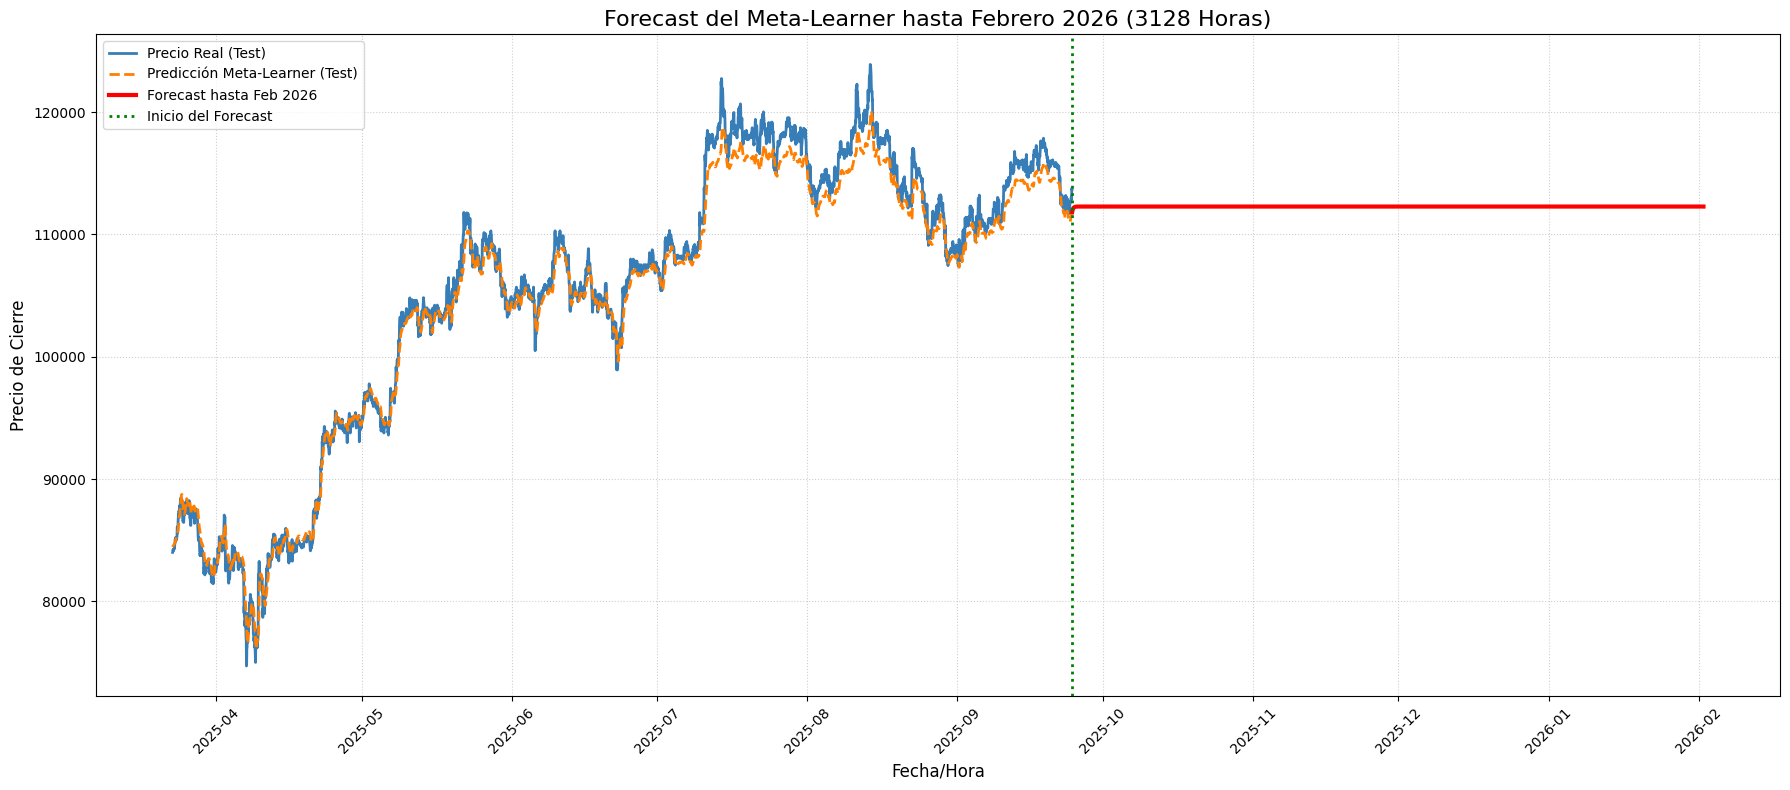

✅ Gráfica de Forecast hasta Febrero 2026 generada.


In [ ]:
## 🚀 BLOQUE DE PREDICCIÓN OUT-OF-SAMPLE (FORECASTING) HASTA FEBRERO 2026

import pandas as pd
import numpy as np
import os
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tqdm import tqdm # 👈 IMPORTACIÓN CLAVE

print("--- INICIO DE FORECASTING HASTA FINALES DE FEBRERO 2026 ---")

# --- 1. DEFINICIÓN DEL HORIZONTE Y FECHA INICIO ---
start_date = data_completa_limpia_test.index[-1] 
end_date = pd.to_datetime('2026-02-1 23:00:00')

future_dates = pd.date_range(start=start_date, end=end_date, freq='H')[1:]
HORIZONTE_HORAS = len(future_dates)
TIMESTEP_HORA_META = 504 

print(f"Prediciendo {HORIZONTE_HORAS} horas hasta: {end_date.date()}")

# --- 2. CONFIGURACIÓN DEL INPUT INICIAL ---
last_scaled_window = scaled_data_final_test[-TIMESTEP_HORA_META:].tolist() 
future_input_list = last_scaled_window
last_unscaled_data = data_completa_limpia_test.values[-TIMESTEP_HORA_META:]
last_unscaled_row = last_unscaled_data[-1] 
CLOSE_IDX = features_new.index('close')
OTHER_FEATURES_INDICES = [i for i in range(len(features_new)) if i != CLOSE_IDX]


# --- 3. BUQUE WALK-FORWARD (PREDICCIÓN PASO A PASO) ---

forecast_scaled = []
forecast_unscaled = []

# 🔑 MODIFICACIÓN CLAVE: Usar tqdm para envolver el rango y mostrar la barra
for i in tqdm(range(HORIZONTE_HORAS), desc="Calculando Forecast (Walk-Forward)", unit="horas"):
    # a) Preparar el input X_t (última ventana de 504)
    X_t = np.array(future_input_list).reshape(1, TIMESTEP_HORA_META, len(features_new))
    
    # b) Generar la predicción escalada del Meta-Learner (verbose=0 para evitar spam)
    pred_lstm_scaled = modelo_lstm_meta.predict(X_t, verbose=0)
    pred_gru_scaled = modelo_gru_meta.predict(X_t, verbose=0)
    pred_scaled_next_close = (pred_lstm_scaled + pred_gru_scaled) / 2
    
    # c) Desescalar solo el valor predicho 'close'
    pred_scaled_reshaped = pred_scaled_next_close.reshape(-1, 1)
    pred_unscaled_next_close = desescalar_prediccion(pred_scaled_reshaped, new_scaler_horario, features_new)[0]
    
    # d) SIMULACIÓN: Crear la fila de 8 features futuras (no escaladas)
    new_unscaled_row = last_unscaled_row.copy() 
    new_unscaled_row[CLOSE_IDX] = pred_unscaled_next_close 
    for j in OTHER_FEATURES_INDICES:
        new_unscaled_row[j] = last_unscaled_data[-1, j] 

    # e) ESCALAR LA NUEVA FILA (8 features)
    new_unscaled_row_reshaped = new_unscaled_row.reshape(1, -1)
    new_scaled_row = new_scaler_horario.transform(new_unscaled_row_reshaped)[0]
    
    # f) ACTUALIZAR EL INPUT Y LAS LISTAS DE RESULTADOS
    forecast_scaled.append(pred_scaled_next_close[0, 0])
    forecast_unscaled.append(pred_unscaled_next_close)
    
    # Actualizar la ventana
    future_input_list.pop(0) 
    future_input_list.append(new_scaled_row.tolist()) 
    
    # Actualizar la base de simulación para el siguiente paso
    last_unscaled_data = np.vstack([last_unscaled_data[1:], new_unscaled_row])
    last_unscaled_row = new_unscaled_row
    
print("\n✅ Predicción walk-forward completada.")


# --- 4. CONSTRUCCIÓN DEL DATAFRAME DE FORECAST Y GRÁFICO ---
# (Esta sección no necesita cambios)

df_forecast = pd.DataFrame({
    'Predicción_MetaLearner': np.array(forecast_unscaled).flatten()
}, index=future_dates)

df_combined = pd.concat([df_results, df_forecast])

plt.figure(figsize=(18, 8))
plt.plot(df_combined['Real'], label='Precio Real (Test)', color='#377eb8', linewidth=2)
plt.plot(df_combined['Predicción'], label='Predicción Meta-Learner (Test)', color='#ff7f00', linestyle='--', linewidth=2)
plt.plot(df_combined['Predicción_MetaLearner'], label='Forecast hasta Feb 2026', color='red', linewidth=3) 

plt.title(f'Forecast del Meta-Learner hasta Febrero 2026 ({HORIZONTE_HORAS} Horas)', fontsize=16)
plt.xlabel('Fecha/Hora', fontsize=12)
plt.ylabel('Precio de Cierre', fontsize=12)
plt.axvline(x=start_date, color='green', linestyle=':', label='Inicio del Forecast', linewidth=2)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print("Gráfica de Forecast hasta Febrero 2026 generada.")